In [1]:
import numpy as np
import imageio
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# Function to load MNIST dataset
def load_mnist():
    NUM_LABELS = 10
    test_images, test_labels = [], []
    train_images, train_labels = [], []

    base_path = "C:/Users/ramki/OneDrive/Desktop/DL/MNIST/MNIST"

    for label in range(NUM_LABELS):
        for image_path in glob.glob(f"{base_path}/Test/{label}/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            letter = [0] * NUM_LABELS
            letter[label] = 1
            test_labels.append(letter)

    for label in range(NUM_LABELS):
        for image_path in glob.glob(f"{base_path}/Train/{label}/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            letter = [0] * NUM_LABELS
            letter[label] = 1
            train_labels.append(letter)

    X_train = np.array(train_images).reshape(-1, 784) / 255.0
    Y_train = np.array(train_labels)
    X_test = np.array(test_images).reshape(-1, 784) / 255.0
    Y_test = np.array(test_labels)

    return X_train, Y_train, X_test, Y_test

In [3]:
X_train, Y_train, X_test, Y_test = load_mnist()

C:\Users\ramki\AppData\Local\Temp\ipykernel_8360\189164474.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\ramki\AppData\Local\Temp\ipykernel_8360\189164474.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # If the number of input channels is not equal to the number of output channels,
        # we need a 1x1 convolution to match the dimensions for the residual connection.
        self.downsample = None
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        
        # If downsample is defined, apply it to the residual
        if self.downsample is not None:
            residual = self.downsample(residual)
        
        out += residual  # Add the residual to the output
        out = self.relu(out)
        return out

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.residual_block1 = ResidualBlock(in_channels=8, out_channels=16, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.residual_block2 = ResidualBlock(in_channels=16, out_channels=32, stride=1)

        self.fc = nn.Linear(in_features=32 * 7 * 7, out_features=10)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.residual_block1(x)
        x = self.pool2(x)

        x = self.residual_block2(x)

        x = x.view(x.size(0), -1)  
        x = self.fc(x)  

        return x  
model = NeuralNetwork()

In [5]:
#mini batch
def random_mini_batches(X, Y, batch_size):
    m = X.shape[0]
    mini_batches = []
    permutation = np.random.permutation(m)
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    num_batches = m // batch_size
    for k in range(num_batches):
        X_mini = shuffled_X[k * batch_size:(k + 1) * batch_size, :]
        Y_mini = shuffled_Y[k * batch_size:(k + 1) * batch_size, :]
        mini_batches.append((X_mini, Y_mini))

    if m % batch_size != 0:
        X_mini = shuffled_X[num_batches * batch_size:, :]
        Y_mini = shuffled_Y[num_batches * batch_size:, :]
        mini_batches.append((X_mini, Y_mini))

    return mini_batches

In [6]:
def train_model(model, X_train, Y_train, X_test, Y_test, iterations=1000, learning_rate=0.001, batch_size=64):
    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_costs, test_costs = [], []
    train_accuracies, test_accuracies = [], []

    for i in range(iterations):
        # Create mini-batches
        mini_batches = random_mini_batches(X_train, Y_train, batch_size)

        for X_mini, Y_mini in mini_batches:
            # Reshape X_mini to [batch_size, 1, 28, 28] for convolutional layers
            X_mini = X_mini.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

            # Forward pass
            outputs = model(X_mini)
            loss = criterion(outputs, torch.argmax(Y_mini, dim=1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i % 10 == 0:
            # Calculate accuracy and cost
            with torch.no_grad():
                # Reshape X_train and X_test for evaluation
                X_train_reshaped = X_train.view(-1, 1, 28, 28)
                X_test_reshaped = X_test.view(-1, 1, 28, 28)

                train_outputs = model(X_train_reshaped)
                train_cost = criterion(train_outputs, torch.argmax(Y_train, dim=1)).item()
                train_accuracy = (torch.argmax(train_outputs, dim=1) == torch.argmax(Y_train, dim=1)).float().mean().item()

                test_outputs = model(X_test_reshaped)
                test_cost = criterion(test_outputs, torch.argmax(Y_test, dim=1)).item()
                test_accuracy = (torch.argmax(test_outputs, dim=1) == torch.argmax(Y_test, dim=1)).float().mean().item()

            train_costs.append(train_cost)
            test_costs.append(test_cost)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            print(f"Iteration {i}: Train Cost = {train_cost:.4f}, Test Cost = {test_cost:.4f}, Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

    return train_costs, test_costs, train_accuracies, test_accuracies

In [7]:
# Initialize the model
start_time = time.time()

model = NeuralNetwork()
train_cost, test_cost, train_accu, test_accu = train_model(
    model, X_train, Y_train, X_test, Y_test, iterations=100, learning_rate=0.001, batch_size=64
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time:.4f} seconds")

Iteration 0: Train Cost = 0.0713, Test Cost = 0.0668, Train Accuracy = 0.9784, Test Accuracy = 0.9795
Iteration 10: Train Cost = 0.0093, Test Cost = 0.0331, Train Accuracy = 0.9965, Test Accuracy = 0.9913
Iteration 20: Train Cost = 0.0033, Test Cost = 0.0490, Train Accuracy = 0.9989, Test Accuracy = 0.9901
Iteration 30: Train Cost = 0.0037, Test Cost = 0.0640, Train Accuracy = 0.9987, Test Accuracy = 0.9895
Iteration 40: Train Cost = 0.0027, Test Cost = 0.0651, Train Accuracy = 0.9991, Test Accuracy = 0.9906
Iteration 50: Train Cost = 0.0017, Test Cost = 0.0655, Train Accuracy = 0.9995, Test Accuracy = 0.9913
Iteration 60: Train Cost = 0.0022, Test Cost = 0.0823, Train Accuracy = 0.9994, Test Accuracy = 0.9900
Iteration 70: Train Cost = 0.0082, Test Cost = 0.1060, Train Accuracy = 0.9978, Test Accuracy = 0.9889
Iteration 80: Train Cost = 0.0033, Test Cost = 0.0974, Train Accuracy = 0.9993, Test Accuracy = 0.9901
Iteration 90: Train Cost = 0.0006, Test Cost = 0.1108, Train Accuracy = 0.

<Figure size 1200x500 with 0 Axes>

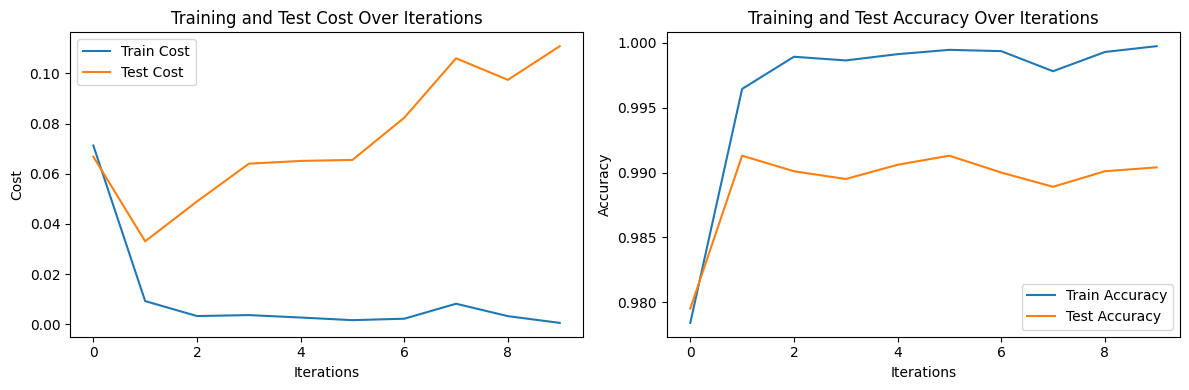

Final Train Cost: 0.0006
Final Test Cost: 0.1108
Final Train Accuracy: 0.9998
Final Test Accuracy: 0.9904


In [12]:
# Plot the learning curves
plt.figure(figsize=(12, 5))
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and test cost
plt.subplot(1, 2, 1)
plt.plot(train_cost, label='Train Cost')
plt.plot(test_cost, label='Test Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Training and Test Cost Over Iterations')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accu, label='Train Accuracy')
plt.plot(test_accu, label='Test Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Iterations')
plt.legend()

plt.tight_layout()
plt.show()

# Print final train and test cost/accuracy
print(f"Final Train Cost: {train_cost[-1]:.4f}")
print(f"Final Test Cost: {test_cost[-1]:.4f}")
print(f"Final Train Accuracy: {train_accu[-1]:.4f}")
print(f"Final Test Accuracy: {test_accu[-1]:.4f}")

In [9]:
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate):
  lg=18
  md=13
  sm=9
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  fig.suptitle(title, y=1.15, fontsize=lg)
  sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} |'
  fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
  # x = range(1, len(train_costs)+1)
  x = np.arange(0, len(train_costs) * 10, 10)
  axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
  axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
  axs[0].set_title('Costs', fontsize=md)
  axs[0].set_xlabel('Iteration', fontsize=md)
  axs[0].set_ylabel('Cost', fontsize=md)
  axs[0].legend(fontsize=sm)
  axs[0].tick_params(axis='both', labelsize=sm)

  # Set the y-axis ticks for the cost plot
  axs[0].set_yticks(np.arange(min(train_costs), max(train_costs), 0.02))
  # Set the y-axis ticks for the accuracy plot
  axs[1].set_yticks(np.arange(min(train_accuracy), max(train_accuracy), 0.02))

  # Optionally use a logarithmic y-scale
  #axs[0].set_yscale('log')
  axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
  axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
  axs[1].set_title('Accuracy', fontsize=md)
  axs[1].set_xlabel('Iterations', fontsize=md)
  axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
  axs[1].legend(fontsize=sm)
  axs[1].tick_params(axis='both', labelsize=sm)

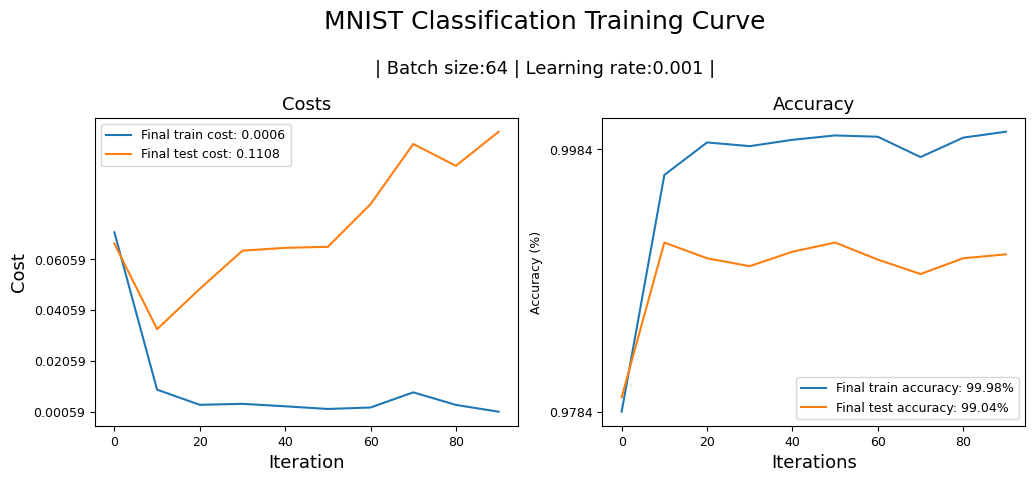

In [10]:
training_curve_plot("MNIST Classification Training Curve", train_cost, test_cost, train_accu, test_accu, batch_size=64, learning_rate=0.001)
plt.show()